# Netflix Prize: Improving Movie Recommendations

In 2006, Netflix launched the **Netflix Prize**, offering **$1 million** to anyone who could improve their movie recommendation system by **10%**. Netflix's algorithm at the time, **CineMatch**, had an **RMSE** of **0.9525**. A team from **AT&T Labs** won the prize by reducing the RMSE to **0.8572**—a major improvement.

### Why Matrix Factorization?

The competition showed that **matrix factorization models** were far superior to traditional **nearest-neighbor** techniques for recommendations. These models allowed Netflix to incorporate:

- **Implicit feedback** (user behavior like clicks/views).
- **Temporal effects** (how preferences change over time).
- **Confidence levels** (weighting interactions based on context).

### Key Results

- **CineMatch RMSE**: 0.9525
- **AT&T Labs RMSE**: 0.8572
- **Improvement**: Over 10%

Matrix factorization remains a core part of Netflix’s recommender system today.

---

### 1. importing packages

In [3]:
import os
import random
import matplotlib
matplotlib.use('notebook')
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

### 2. Data Preprocessing

##### 2.1 Converting all the txt file to one file which will be in user, movie, rating, Date format

In [4]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

    row = list()
    files=['data/combined_data_1.txt','data/combined_data_2.txt',
           'data/combined_data_3.txt', 'data/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000627


##### 2.2 Reading Data in CSV file

In [5]:
start = datetime.now()
df = pd.read_csv('data.csv', sep=',',
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

df.sort_values(by='date', inplace=True)
print('Time taken :', datetime.now() - start)

Done.

Time taken : 0:00:48.313306


In [6]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [8]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


##### 2.3 Train-Test split

In [9]:
start = datetime.now()
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")
print('Time taken :', datetime.now() - start)

Time taken : 0:04:07.156950


In [10]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


In [11]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


##### 2.4 Extracting day_of_week imformation from the existing data column from Dataset

In [12]:
pd.options.mode.chained_assignment = None

train_df['day_of_week'] = train_df.date.dt.day_name()

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


### 3. Exploratory data analysis (EDA) on training Dataset

In [13]:
def human(num, units = 'm'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

##### 3.1 Graph for Number of rating per year in Training data

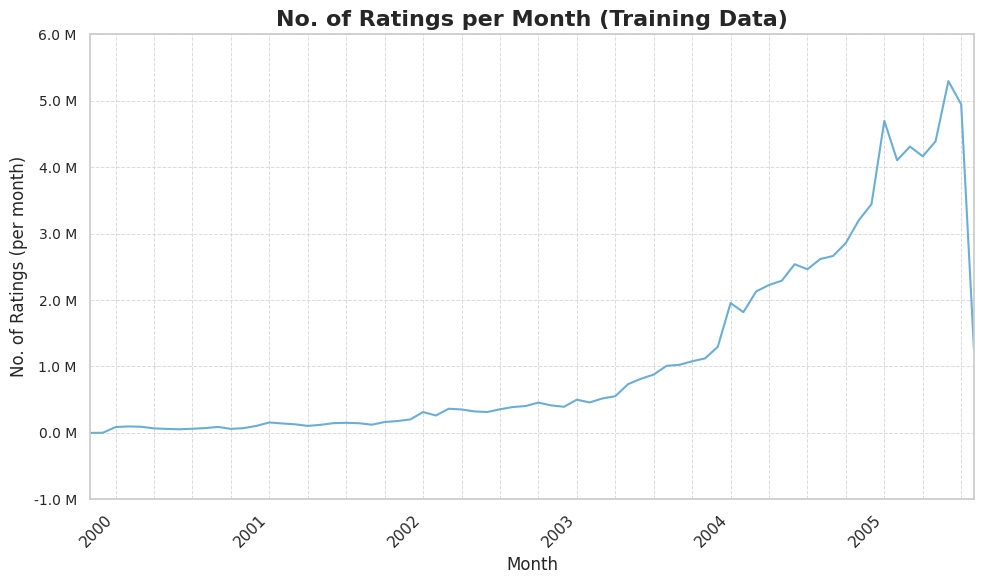

In [18]:
sns.set(style="whitegrid")

ax = train_df.resample('ME', on='date')['rating'].count().plot(
    figsize=(10, 6), color=sns.color_palette("Blues", 1)[0])

ax.set_title('No. of Ratings per Month (Training Data)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('No. of Ratings (per month)', fontsize=12)

plt.xticks(rotation=45, ha='right')

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()], fontsize=10)

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()

##### 3.2 quantiles plot of number of movies rated by user

In [21]:
no_of_rated_movies_per_user = train_df.groupby('user')['rating'].count()
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

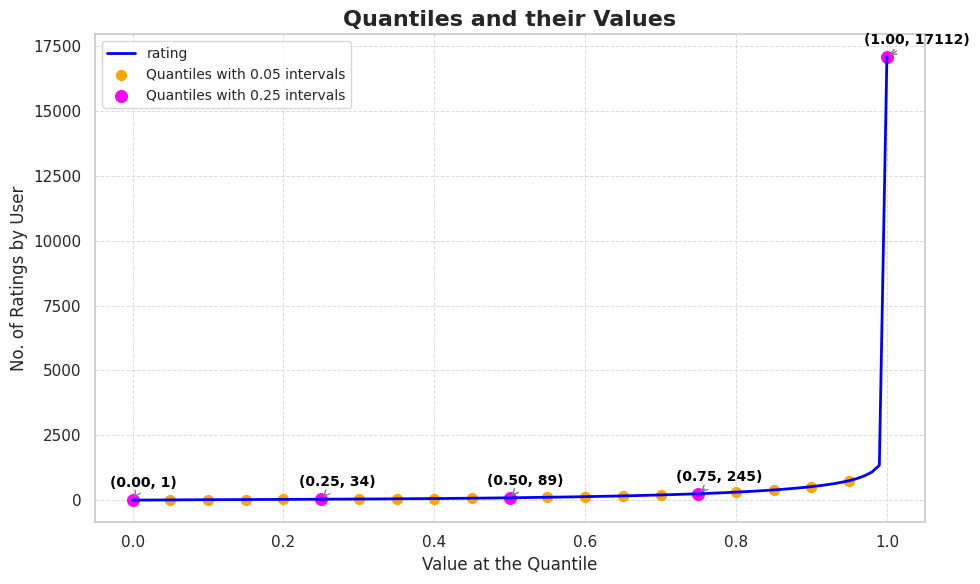

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.title("Quantiles and their Values", fontsize=16, fontweight='bold')


quantiles.plot(color='blue', linewidth=2)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="Quantiles with 0.05 intervals", s=50)
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='magenta', label="Quantiles with 0.25 intervals", s=70)


plt.ylabel('No. of Ratings by User', fontsize=12)
plt.xlabel('Value at the Quantile', fontsize=12)
plt.legend(loc='best', fontsize=10)

for x, y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(text=f"({x:.2f}, {y})", xy=(x, y), xytext=(x-0.03, y+500),
                 textcoords='data', arrowprops=dict(arrowstyle="->", color='gray'),
                 fontsize=10, fontweight='bold', color='black')

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()

##### 3.3 plot for number of ratings per weekday

/tmp/ipykernel_1992973/1512034742.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=train_df, ax=ax, palette='Blues_d')


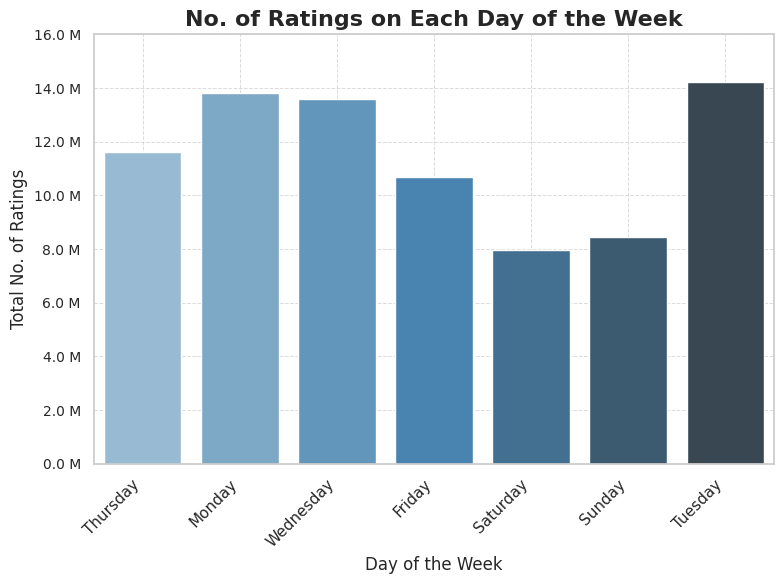

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x='day_of_week', data=train_df, ax=ax, palette='Blues_d')
plt.title('No. of Ratings on Each Day of the Week', fontsize=16, fontweight='bold')
plt.ylabel('Total No. of Ratings', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()], fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

##### 3.4 BOX plot for value of ratings given on each weekday

/tmp/ipykernel_1992973/2201377110.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='rating', x='day_of_week', data=train_df, palette='coolwarm')


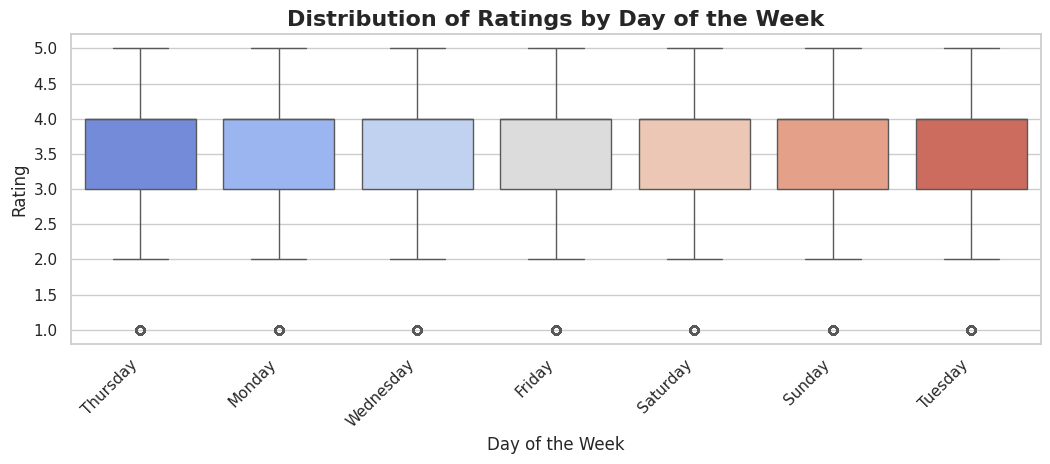

0:02:32.955744


In [26]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df, palette='coolwarm')
plt.title('Distribution of Ratings by Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(datetime.now() - start)

### 4. Creating sparse matric representation our data

##### 4.1 Creating sparse matric representation our train data

In [27]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else:
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)

    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:00:44.446493


##### 4.2 Creating sparse matric representatio our test data

In [28]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else:
    print("We are creating sparse_matrix from the dataframe..")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))

    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:00:12.237850


### 5. Function for User-user similarity

* **"Users who have agreed in the past tends to agree in the
future"**. \
With this idea, we aimed to find similar users using cosine similarity
$$
\begin{align}
             sim(u_{i}, u_{j}) = \dfrac {u^T_{i} \cdot u_{j}} {\left\| u_{i}\right\| _{2}\left\| u_{j}\right\| _{2}}
\end{align}
$$
         

In [29]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind))
    time_taken = list()

    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")

    start = datetime.now()
    temp = 0
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))

    if verbose:
      print('Creating Sparse matrix from the computed similarities')

    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()

    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

### 6. Function Sampling data from the sparse matrix

* Original Train dataset
> Total no of ratings : 80384405\
  Total No of Users   : 405041\
   Total No of movies  : 17424

* Original Test dataset
> Total no of ratings : 20096102\
  Total No of Users   : 349312\
  Total No of movies  : 17757

* Because of the hardware constrain we are sampling 9000 users and 1200 movies from the train data and 4000 users and 800 movies from the test data.

In [30]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )

    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')

    return sample_sparse_matrix

##### 6.1 sampling train data from the sparse matrix representation of our train data

In [31]:
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=9000, no_movies=1200,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (9000 1200)
Sampled Matrix : Ratings -- 131824
Saving it into disk for furthur usage..
Done..

0:00:20.687115


##### 6.2 sampling test data from the sparse matrix representation of our test data

In [32]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=4000, no_movies=800,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (4000 800)
Sampled Matrix : Ratings -- 10549
Saving it into disk for furthur usage..
Done..

0:00:05.213580


In [33]:
sample_train_averages = dict()

In [34]:
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5532755795606263}

In [35]:
def get_average_ratings(sparse_matrix, of_users):

    ax = 1 if of_users else 0

    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix!=0
    no_of_ratings = is_rated.sum(axis=ax).A1

    u,m = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m)
                                    if no_of_ratings[i] !=0}

    return average_ratings

In [36]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.8857142857142857


In [40]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n Average rating of movie 15153 :',sample_train_averages['movie'][15153])


 Average rating of movie 15153 : 2.675


In [39]:
print('\n No. of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No. of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No. of ratings in Our Sampled train matrix is : 131824


 No. of ratings in Our Sampled test  matrix is : 10549



### 7 Data preparation for Xgboost and Surprise Models

##### 7.2 creating training dataset with 13 hand crafted feature which will be used in Xgboost-1



1.   GAvg: Average rating of all the movie ratings.
2.   UAvg: Average rating of user($u_{i}$). Encodes how critical
3.   MAvg: Average rating of movie($m_{j}$). Encodes how popular
4.   Similar users rating of this movie($m_{j}$): By using the user-user similarity we will find the list of the users who are similar to the user ($u_{i}$), from this list we will select top 5 user who has watched the movie ($m_{j}$), and the rating given by these selected similar user to movie($m_{j}$) will become our features(sur1, sur2, sur3, sur4, sur5)..
5.   Similar movies rated by this user($u_{i}$): By using the movie-movie similarity we will find the list of the similar movies watched by the user ($u_{i}$), from this list, ratings for top 5 similar movies, will become our features(smr1, smr2, smr3, smr4, smr5).



In [41]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [42]:
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(sample_train_averages['user'][user])
            row.append(sample_train_averages['movie'][movie])
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count)%10000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
print(datetime.now() - start)

preparing 131824 tuples for the dataset..

Done for 10000 rows----- 0:22:27.137769
Done for 20000 rows----- 0:44:42.529832
Done for 30000 rows----- 1:07:00.565094
Done for 40000 rows----- 1:29:00.678268
Done for 50000 rows----- 1:50:58.585291
Done for 60000 rows----- 2:12:56.723093
Done for 70000 rows----- 2:34:56.577104
Done for 80000 rows----- 2:56:53.614664
Done for 90000 rows----- 3:18:52.551722
Done for 100000 rows----- 3:40:49.973493
Done for 110000 rows----- 4:02:47.375974
Done for 120000 rows----- 4:24:49.454020
Done for 130000 rows----- 4:46:46.826475
4:50:47.345434


##### 7.3 Creating panda dataframe for the train dataset Xgboost-1 to diplay the handcrafted 13 features

In [43]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,692,5317,3.553276,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.392507,4
1,692,14621,3.553276,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.333477,4
2,1179,2239,3.553276,5.0,3.0,3.0,2.0,2.0,3.0,5.0,2.0,4.0,3.0,3.526316,2.833333,5
3,1179,2356,3.553276,3.0,2.0,1.0,4.0,3.0,4.0,3.0,3.0,5.0,4.0,3.526316,2.446429,2
4,1179,4341,3.553276,5.0,5.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,5.0,3.526316,3.363817,3


##### 7.5 creating test dataset with 13 hand crafted feature which will be used in Xgboost-1 for testing

In [44]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)


In [45]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            try:
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:]
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            except (IndexError, KeyError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise

            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:]
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            row.append(rating)
            count = count + 1
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count)%1000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)

preparing 10549 tuples for the dataset..

Done for 1000 rows----- 0:02:15.449793
Done for 2000 rows----- 0:04:31.500000
Done for 3000 rows----- 0:06:47.536971
Done for 4000 rows----- 0:09:03.399883
Done for 5000 rows----- 0:11:19.309382
Done for 6000 rows----- 0:13:36.618324
Done for 7000 rows----- 0:15:53.924289
Done for 8000 rows----- 0:18:11.287703
Done for 9000 rows----- 0:20:28.636766
Done for 10000 rows----- 0:22:45.904056
 0:24:01.238719


##### 7.6 Creating panda dataframe for the test dataset for Xgboost-1

In [46]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,7,13072,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,5
1,126,2212,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,5
2,126,3418,3.553276,2.000000,4.000000,3.000000,2.000000,5.000000,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.290323,5
3,126,13115,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,5


### 8. Convertion of dataset in which surprise Library works

* From train sampled sparse matrix we are creating data in user, movie and rating format specified by the surprise library, for the conversion we are using Dataset.load_from_df method provied by surprise library

In [47]:
from surprise import Reader, Dataset

In [48]:
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset()

In [49]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(7, 13072, 5), (126, 2212, 5), (126, 3418, 5)]

In [50]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

### 9. Creating Xgboost model

In [51]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    train_results = dict()
    test_results = dict()
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test)
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
    return train_results, test_results


In [52]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])

    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

def run_surprise(algo, trainset, testset, verbose=True):
    '''
        return train_dict, test_dict

        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    train = dict()
    test = dict()

    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))

    st = datetime.now()
    print('Evaluating the model with train data..')
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))

    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))

    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings

    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))

    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings

    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    return train, test

In [53]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

### 10. XgBoost-13 with 13 Features

Training the model..
[23:30:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/home/shantanu/miniconda3/envs/sarvesh/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:01.367501

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1469005696747614
MAPE :  32.19581707015769


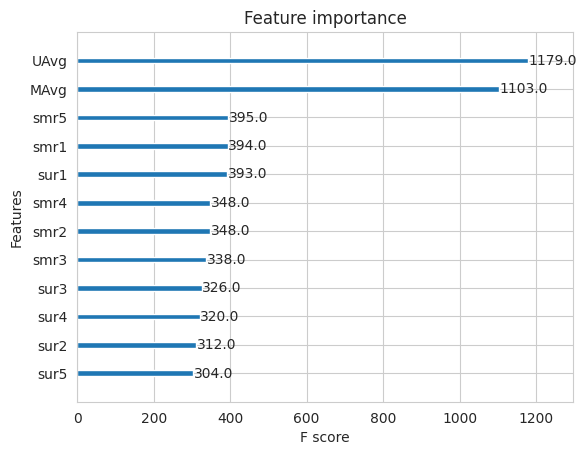

In [ ]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### 11. Surprise- BaseLine

In Surprise, the baseline model is a simple model that predicts the rating for each item and user. The predicted rating for a given user-item pair is calculated as follows:
\begin{align}
    \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i}
\end{align}
where,


-$\mu $ : Average of all trainings in training data.\
-$b_u$ : User bias\
-$b_i$ : Item bias (movie biases)


Surprise provides a 'BaselineOnly' class that implements this baseline model. We have created an instance of 'BaselineOnly' and fit it to our data using the fit() method. It use the MSE loss with L2 regulariser as the optimizing function. The expression for the same is given by-
\begin{align}
    \arg \min_{\textbf{b_u, b_i}} \sum_{r_{ui} \in R_{train}} (\left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right)).
\end{align}

In [ ]:
from surprise import BaselineOnly

In [ ]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

models_evaluation_train['bsl_algo'] = bsl_train_results
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.657626 

Evaluating the model with train data..
time taken : 0:00:00.476155
---------------
Train Data
---------------
RMSE : 0.9352501242493785

MAPE : 29.621523191097044

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.058623
---------------
Test Data
---------------
RMSE : 1.0697024551739118

MAPE : 34.73596050802977

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:01.192652


In [ ]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.553276,4.0,5.0,1.0,5.0,3.0,5.0,2.0,5.0,3.0,3.0,3.366667,4.066667,4,3.850205
1,99865,33,3.553276,5.0,5.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,3.639344,4.066667,5,3.329564


In [ ]:
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,5,3.553276
1,941866,71,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,4,3.553276


### 11. XgBoost-14 with 14 Features (13 handcrafted and output of baseline model)

Training the model..
[23:30:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/home/shantanu/miniconda3/envs/sarvesh/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:03.134396

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.122584002182969
MAPE :  32.592387852836154


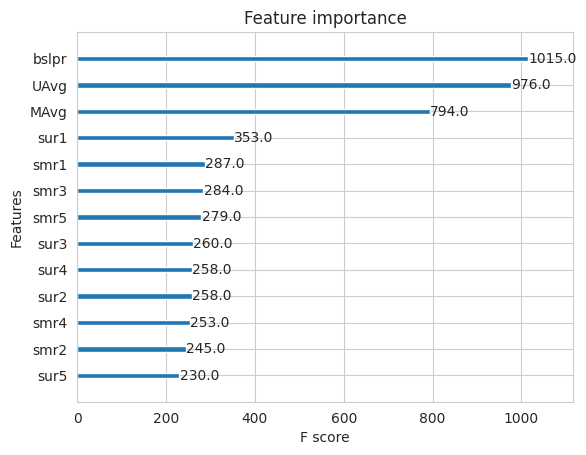

In [ ]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


### 12. Surprise KNN

Surprise KNN Model using user-user similarity While creating handcrafted features (sur1, sur2, sur3, sur4, sur5) we have only focused on 5 similar(nearest) users. Thinking on similar lines, Surprise library has this awesome implementation of looking at K nearest neighbours(users), the KNN model, to predict the ratings. The expression for the same is given by -
\begin{align} \bar{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}
where,
    
-$b_{ui}$: Baseline prediction of (user,movie) rating \
-$\pmb{N_i^k (u)}$: Set of K similar users (neighbours) of user $u_{i}$ who rated movie $m_{j}$  \
-$\pmb{sim (u, v)}$: Similarity between users u and v Generally, cosine similarity or Pearson correlation coefficient is used. But Surprise uses shrunk Pearson-baseline correlation coefficient, which is based on the pearson Baseline similarity.

* same way we wll also use the output of Surprise KNN Model using movie-movie similarity
\begin{align}
    \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)}
\end{align}

where,
    
-$b_{ui}$: Baseline prediction of (user,movie) rating \
-$\pmb{N_u^k (i)}$: Set of K similar movies (neighbours) of user $u_{i}$ who rated movie $m_{j}$  \
-$\pmb{sim (i, j)}$: Similarity between movies i and j Generally, cosine similarity or Pearson correlation coefficient is used. But Surprise uses shrunk Pearson-baseline correlation coefficient, which is based on the pearson Baseline similarity.   

In [ ]:
from surprise import KNNBaseline

In [ ]:
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              }
bsl_options = {'method': 'sgd'}

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:07.423937 

Evaluating the model with train data..
time taken : 0:00:49.668558
---------------
Train Data
---------------
RMSE : 0.34910729348179903

MAPE : 9.583925071791903

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.072268
---------------
Test Data
---------------
RMSE : 1.0697479937154935

MAPE : 34.781087228133536

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:57.164934


In [ ]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              }
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.741675 

Evaluating the model with train data..
time taken : 0:00:05.493469
---------------
Train Data
---------------
RMSE : 0.3476982696336578

MAPE : 9.162601873893975

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.063738
---------------
Test Data
---------------
RMSE : 1.0698742035453888

MAPE : 34.78044266886377

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:06.299061


In [ ]:
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.553276,4.0,5.0,1.0,5.0,3.0,5.0,2.0,5.0,3.0,3.0,3.366667,4.066667,4,3.850205,3.905401,3.840851
1,99865,33,3.553276,5.0,5.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,3.639344,4.066667,5,3.329564,3.139832,3.101314


In [ ]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,5,3.553276,3.553276,3.553276
1,941866,71,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,4,3.553276,3.553276,3.553276


### 13. XGboost-16 with 16 Features (13 handcrafted, output of baseline model and output of surprise KNN)

Training the model..


/home/shantanu/miniconda3/envs/sarvesh/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:03.308353

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.132568352359465
MAPE :  32.28808362649644


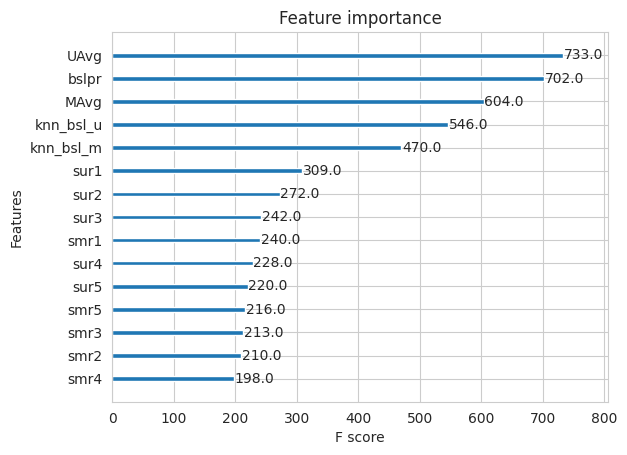

In [ ]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(xgb_knn_bsl)
plt.show()

### 14. Surprise SVD

Matrix Factorization (SVD):\
The famous SVD algorithm, as popularized by Simon Fite during the Netflix Prize is,
\begin{align}
\large  r_{ui}^* = \mu + b_u + b_i + q_i^Tp_u
\end{align}


$\pmb q_i$ - Representation of item(movie) in latent factor space\
$\pmb p_u$ - Representation of user in new latent factor space

\
Optimization problem with user item interactions and regularization (to avoid overfitting)
\begin{align}
\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - r_{ui}^* \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)
\end{align}
The minimization is performed by a very straightforward stochastic gradient descent, The predicted result $r_{ui}^*$ will be again used later to train  XgBoost Regression Using 18 features

In [ ]:
from surprise import SVD

In [ ]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)
models_evaluation_train['svd'] = svd_train_results
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:01.173310 

Evaluating the model with train data..
time taken : 0:00:00.777814
---------------
Train Data
---------------
RMSE : 0.6558331059734974

MAPE : 19.808208315214067

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.062544
---------------
Test Data
---------------
RMSE : 1.0698761361242832

MAPE : 34.71054045263497

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:02.013855


### 15. SVD++

The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
\begin{align}
 \large r_{ui}^{'} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)
\end{align}

$ \pmb{I_u}$ - the set of all items rated by user u\
$\pmb{y_j}$ - Our new set of item factors that capture implicit ratings.



In [1]:
from surprise import SVDpp

In [2]:
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

models_evaluation_train['svdpp'] = svdpp_train_results
models_evaluation_test['svdpp'] = svdpp_test_results


NameError: name 'run_surprise' is not defined

In [ ]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.553276,4.0,5.0,1.0,5.0,3.0,5.0,2.0,...,3.0,3.0,3.366667,4.066667,4,3.850205,3.905401,3.840851,3.829412,4.207834
1,99865,33,3.553276,5.0,5.0,4.0,4.0,5.0,5.0,4.0,...,4.0,5.0,3.639344,4.066667,5,3.329564,3.139832,3.101314,3.400645,3.464591


In [ ]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,...,3.553276,3.553276,3.553276,3.553276,5,3.553276,3.553276,3.553276,3.553276,3.553276
1,941866,71,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,3.553276,...,3.553276,3.553276,3.553276,3.553276,4,3.553276,3.553276,3.553276,3.553276,3.553276


### 16. XGboost-18 with 18 Features (13 handcrafted, output of baseline model ,output of surprise KNN,Output of SVD and output of SVD++)

Training the model..


/home/shantanu/miniconda3/envs/sarvesh/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Done. Time taken : 0:00:03.464448

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1814834683612185
MAPE :  31.41329740409689


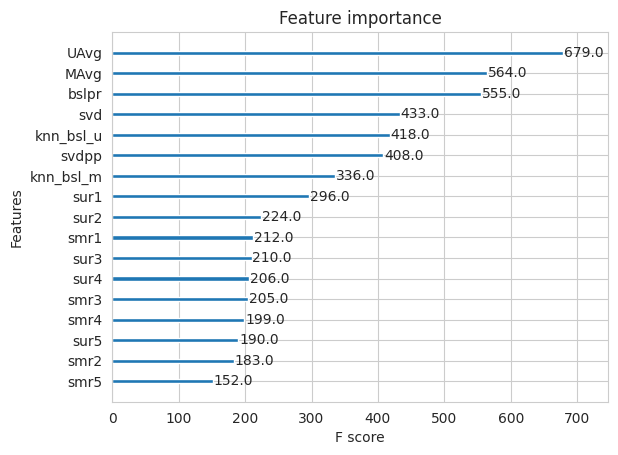

In [ ]:
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

xgb.plot_importance(xgb_final)
plt.show()

### 17. Final RMSE Loss calculation on Test data

In [ ]:
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

bsl_algo          1.0697024551739118
knn_bsl_u         1.0697479937154935
knn_bsl_m         1.0698742035453888
svd               1.0698761361242832
svdpp              1.070294929392826
xgb_all_models    1.0777246644455034
xgb_bsl            1.122584002182969
xgb_knn_bsl        1.132568352359465
first_algo        1.1469005696747614
xgb_final         1.1814834683612185
Name: rmse, dtype: object

### References

We would like to acknowledge below works for inspiring this implementation:

- [**The Netflix Prize — How Even AI Leaders Can Trip Up**](https://towardsdatascience.com/the-netflix-prize-how-even-ai-leaders-can-trip-up-5c1f38e95c9f)  
  (A detailed explanation of the Netflix Prize and its challenges)

- [**Netflix Prize Code by Alex Wiltschko**](https://github.com/alexbw/Netflix-Prize)  
  (Top 150 finalist in the Netflix Prize competition)

- [**Netflix Recommendations: Beyond the 5 Stars (Part 1)**](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)  
  (An insightful blog by the Netflix engineering team on recommendation systems)

- [**Netflix Recommendations: Beyond the 5 Stars (Part 2)**](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5)  
  (Continuation of the Netflix engineering team's blog on their recommendation algorithm)

- [**Harsh Raj’s Paper Implementation: Matrix Factorization Recommender Systems**](https://github.com/harshraj11584/Paper-Implementation-Matrix-Factorization-Recommender-Systems-Netflix)  
  (A GitHub repository that implements matrix factorization techniques for Netflix’s recommendation system)

- [**Movie Recommendation Code by Sivasubramanian B**](https://github.com/storieswithsiva/Movie-Recommendation-Netflix)  
  (A GitHub repository showcasing a movie recommendation system for Netflix)

- [**Matrix Factorization Techniques for Recommender Systems**](https://ieeexplore.ieee.org/document/5197422) by Y. Koren, R. Bell, and C. Volinsky  
  (A highly influential paper on matrix factorization techniques, published in *Computer*, vol. 42, no. 8, pp. 30-37, Aug. 2009)

- [**Netflix Prize Challenge Winner Paper by Y. Koren**](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf)  
  (The official paper written by the winner of the Netflix Prize, Y. Koren)

- [**Kaggle Netflix Prize Dataset**](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data/code)  
  (Link to the Netflix Prize dataset on Kaggle)
